In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import cv2
from pathlib import Path

/Users/anshulagarwal/Downloads/fruitcassificationusingdeeplearning/.venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
# ## 2. Configuration and Setup

# %%
# Configuration
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 6  # Adjust based on your dataset

# Set random seeds for reproducibility
np.random.seed(42)

In [3]:
# ## 3. Data Loading and Preprocessing
# 
# **Note:** Update the DATA_DIR path to point to your fruit dataset.

# ```

# %%
# Update this path to your dataset location
DATA_DIR = '/Users/anshulagarwal/Downloads/fruitcassificationusingdeeplearning/Fruitimagesdataset'
TRAIN_DIR = os.path.join(DATA_DIR, '/Users/anshulagarwal/Downloads/fruitcassificationusingdeeplearning/Fruitimagesdataset/train')
VAL_DIR = os.path.join(DATA_DIR, '/Users/anshulagarwal/Downloads/fruitcassificationusingdeeplearning/Fruitimagesdataset/validation')

# Data Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Get class names
class_names = list(train_generator.class_indices.keys())
NUM_CLASSES = len(class_names)
print(f"Classes: {class_names}")
print(f"Number of classes: {NUM_CLASSES}")

# %% [markdown]

Found 13452 images belonging to 5 classes.
Found 4004 images belonging to 5 classes.
Classes: ['apple fruit', 'banana fruit', 'grapes fruit', 'mango fruit', 'strawberry fruit']
Number of classes: 5


In [4]:
# ## 4. Visualize Sample Images

# %%
def plot_sample_images(generator, class_names, n_images=9):
    """Plot sample images from the dataset"""
    plt.figure(figsize=(12, 12))
    
    # Get a batch of images
    images, labels = next(generator)
    
    for i in range(min(n_images, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        class_idx = np.argmax(labels[i])
        plt.title(f"Class: {class_names[class_idx]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


In [5]:
# ## 5. Build CNN Model

# %%
def create_cnn_model(input_shape, num_classes):
    """
    Create a CNN model for fruit classification
    """
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Fourth Convolutional Block
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Flatten and Dense Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create the model
model = create_cnn_model(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    num_classes=NUM_CLASSES
)

# Display model architecture
model.summary()

# %% [markdown]

/Users/anshulagarwal/Downloads/fruitcassificationusingdeeplearning/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,244,101 (20.00 MB)

 Trainable params: 5,242,117 (20.00 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [6]:
# ## 6. Compile Model

# %%
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# %% [markdown]

In [7]:
# ## 7. Setup Callbacks

# %%
# Callbacks for training
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

# %% [markdown]

In [8]:
# ## 8. Train the Model

# %%
# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

# %% [markdown]

Epoch 1/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 128s 298ms/step - accuracy: 0.4202 - loss: 1.6884 - val_accuracy: 0.3287 - val_loss: 1.5026 - learning_rate: 0.0010
Epoch 2/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 124s 294ms/step - accuracy: 0.5387 - loss: 1.1621 - val_accuracy: 0.6371 - val_loss: 0.9233 - learning_rate: 0.0010
Epoch 3/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 126s 300ms/step - accuracy: 0.5949 - loss: 1.0371 - val_accuracy: 0.6089 - val_loss: 0.9508 - learning_rate: 0.0010
Epoch 4/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 127s 302ms/step - accuracy: 0.6256 - loss: 0.9685 - val_accuracy: 0.6009 - val_loss: 0.9829 - learning_rate: 0.0010
Epoch 5/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 127s 302ms/step - accuracy: 0.6477 - loss: 0.9267 - val_accuracy: 0.5689 - val_loss: 1.0893 - learning_rate: 0.0010
Epoch 6/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 123s 293ms/step - accuracy: 0.6539 - loss: 0.9042 - val_accuracy: 0.6898 - val_loss: 0.8168 - learning_rate: 0.0010
Epoch 7/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 122s 290ms/step - accura

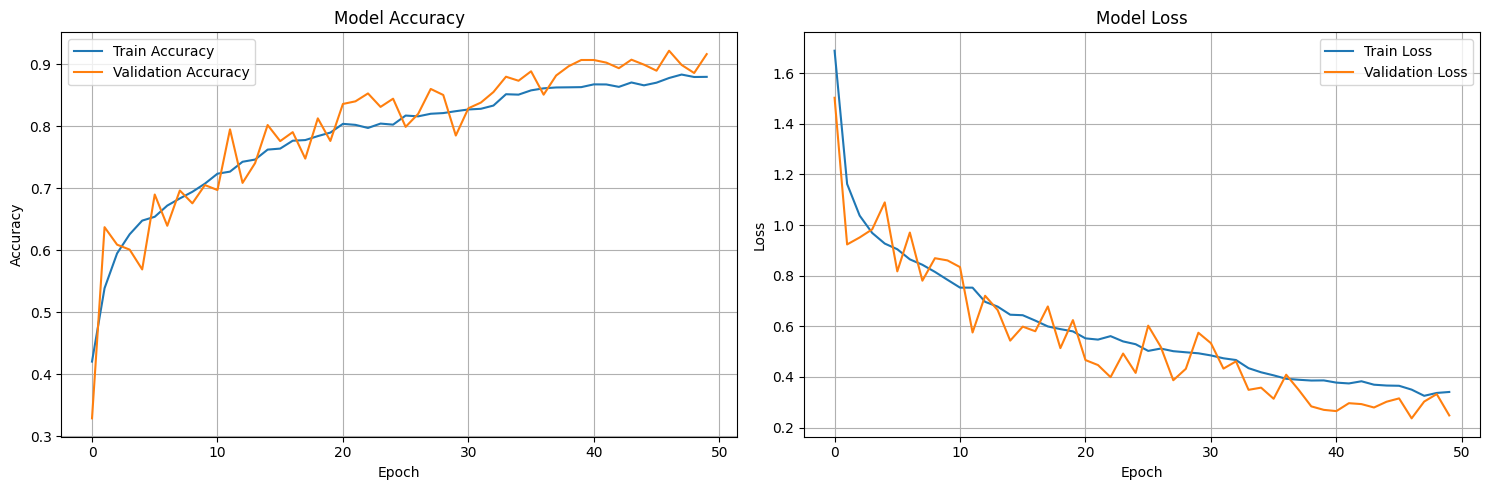

In [9]:
# ## 9. Visualize Training History

# %%
def plot_training_history(history):
    """Plot training and validation accuracy and loss"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    # Loss plot
    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

# %% [markdown]

In [10]:
# ## 10. Evaluate Model

# %%
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# %% [markdown]

126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.9218 - loss: 0.2363

Validation Loss: 0.2363
Validation Accuracy: 0.9218


126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step


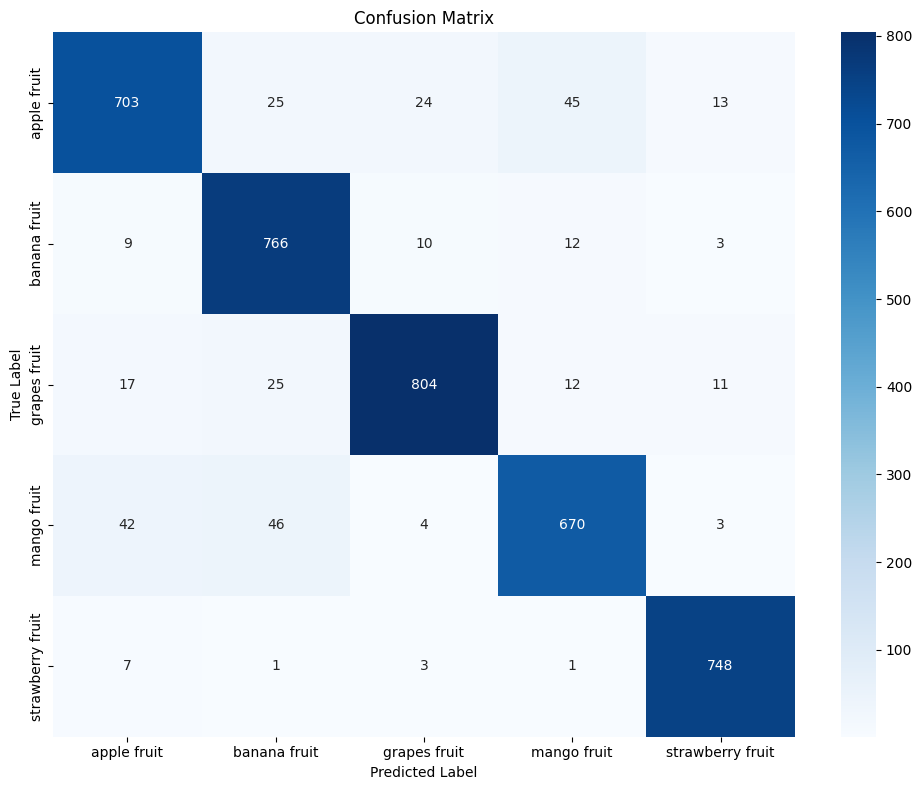


Classification Report:
                  precision    recall  f1-score   support

     apple fruit       0.90      0.87      0.89       810
    banana fruit       0.89      0.96      0.92       800
    grapes fruit       0.95      0.93      0.94       869
     mango fruit       0.91      0.88      0.89       765
strawberry fruit       0.96      0.98      0.97       760

        accuracy                           0.92      4004
       macro avg       0.92      0.92      0.92      4004
    weighted avg       0.92      0.92      0.92      4004



In [11]:
# ## 11. Confusion Matrix and Classification Report

# %%
# Get predictions
validation_generator.reset()
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# %% [markdown]

In [13]:
from sklearn.metrics import accuracy_score

# Find best and worst predicted classes based on validation set

# Calculate per-class accuracy
per_class_accuracies = []

for i, class_name in enumerate(class_names):
    idx = np.where(y_true == i)[0]
    class_acc = accuracy_score(y_true[idx], y_pred_classes[idx])
    per_class_accuracies.append(class_acc)
    print(f"Accuracy for class '{class_name}': {class_acc:.4f}")

# Find best and worst class
best_class_idx = np.argmax(per_class_accuracies)
worst_class_idx = np.argmin(per_class_accuracies)

print(f"\nBest predicted class: {class_names[best_class_idx]} (Accuracy: {per_class_accuracies[best_class_idx]:.4f})")
print(f"Worst predicted class: {class_names[worst_class_idx]} (Accuracy: {per_class_accuracies[worst_class_idx]:.4f})")

Accuracy for class 'apple fruit': 0.8679
Accuracy for class 'banana fruit': 0.9575
Accuracy for class 'grapes fruit': 0.9252
Accuracy for class 'mango fruit': 0.8758
Accuracy for class 'strawberry fruit': 0.9842

Best predicted class: strawberry fruit (Accuracy: 0.9842)
Worst predicted class: apple fruit (Accuracy: 0.8679)


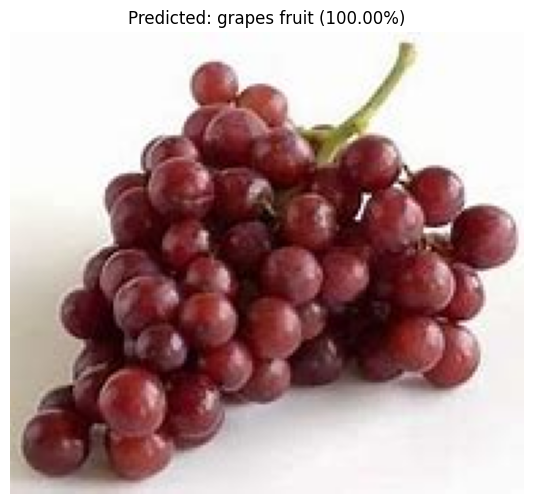


Class Probabilities:
apple fruit: 0.00%
banana fruit: 0.00%
grapes fruit: 100.00%
mango fruit: 0.00%
strawberry fruit: 0.00%


In [27]:
# ## 12. Prediction Function

# %%
def predict_fruit(image_path, model, class_names):
    """
    Predict the class of a single fruit image
    """
    # Load and preprocess image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img_array = img_resized / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Make prediction
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx]
    
    # Display result
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_class_idx]} ({confidence*100:.2f}%)")
    plt.axis('off')
    plt.show()
    
    # Print all class probabilities
    print("\nClass Probabilities:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {predictions[0][i]*100:.2f}%")
    
    return class_names[predicted_class_idx], confidence

# Example usage (uncomment and update path):
predicted_class, confidence = predict_fruit('/Users/anshulagarwal/Downloads/fruitcassificationusingdeeplearning/Fruitimagesdataset/grapes fruit/11.jpg', model, class_names)

# %% [markdown]

In [17]:
# ## 13. Save the Model

# %%
# Save the entire model
model.save('fruit_classifier_model.h5')
print("Model saved as 'fruit_classifier_model.h5'")

# Save model architecture as JSON
model_json = model.to_json()
with open("fruit_classifier_architecture.json", "w") as json_file:
    json_file.write(model_json)

# Save weights separately (filename must end with .weights.h5 for TF >=2.11)
model.save_weights("fruit_classifier.weights.h5")
print("Model architecture and weights saved separately")


Model saved as 'fruit_classifier_model.h5'
Model architecture and weights saved separately


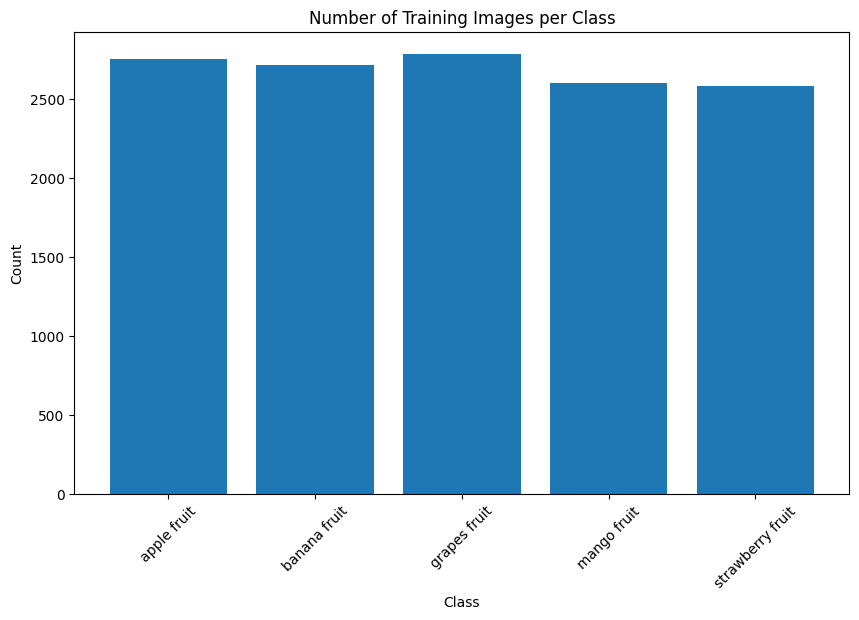

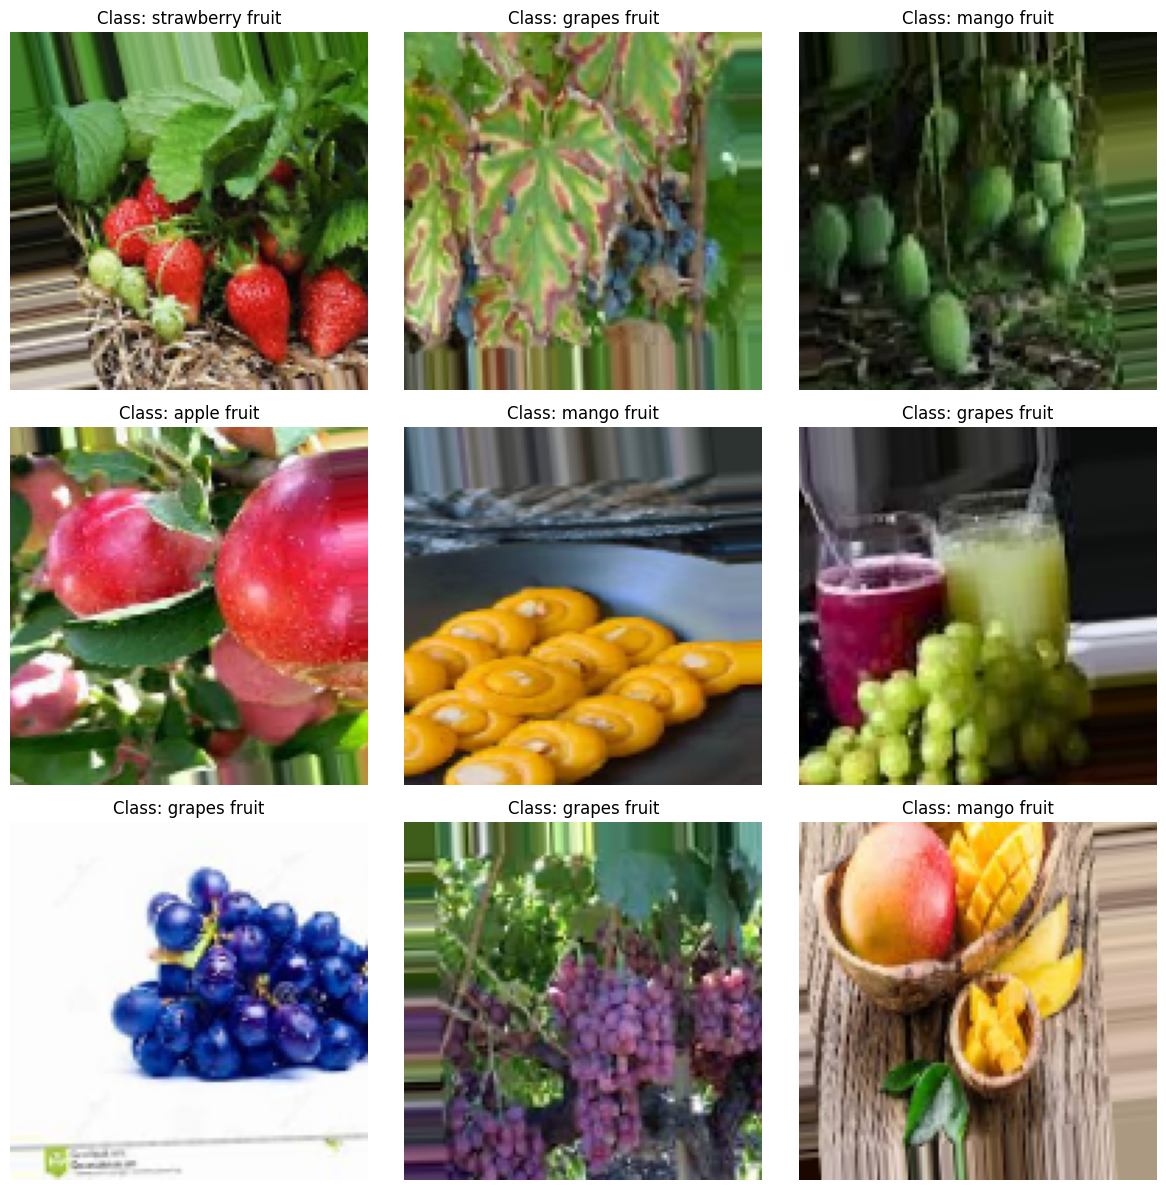

Image batch shape: (32, 128, 128, 3)
Image data type: float32


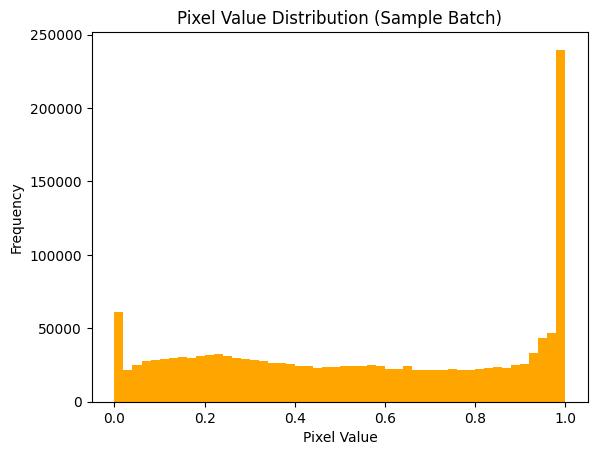

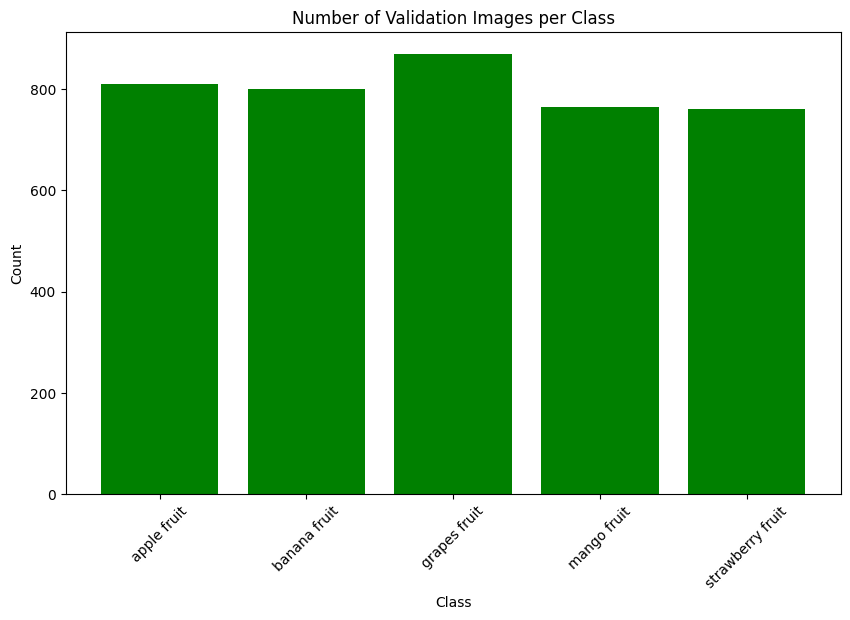

Training class distribution: Counter({np.int32(2): 2787, np.int32(0): 2756, np.int32(1): 2721, np.int32(3): 2604, np.int32(4): 2584})
Validation class distribution: Counter({np.int32(2): 869, np.int32(0): 810, np.int32(1): 800, np.int32(3): 765, np.int32(4): 760})
Sample image shapes (HxW): [[128 128]
 [128 128]
 [128 128]]
Number of duplicate filenames in training set: 1170


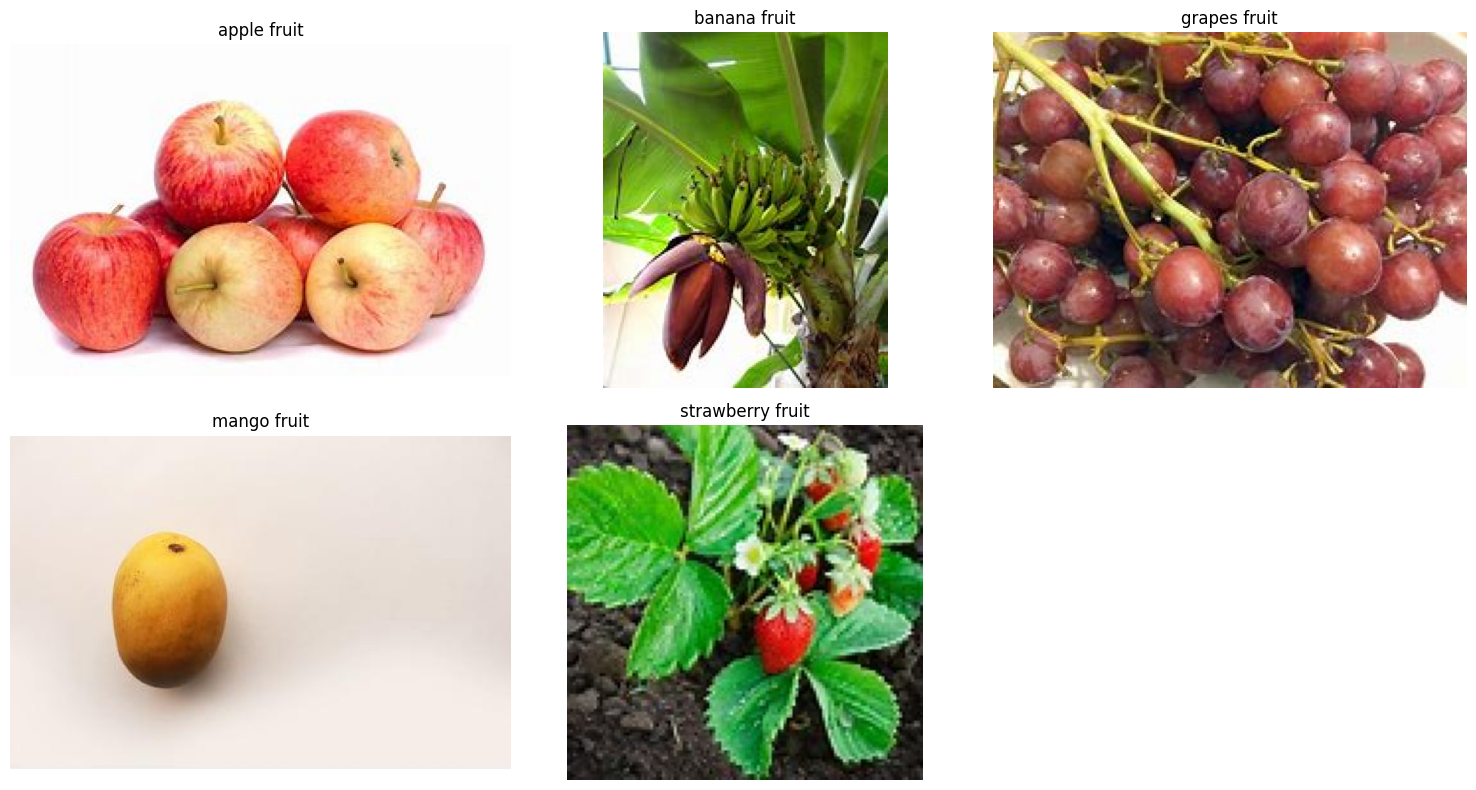

Class indices mapping: {'apple fruit': 0, 'banana fruit': 1, 'grapes fruit': 2, 'mango fruit': 3, 'strawberry fruit': 4}


In [16]:
import collections

# ## 1. Exploratory Data Analysis (EDA)

# 1. Number of images per class

train_class_counts = collections.Counter(train_generator.classes)
plt.figure(figsize=(10, 6))
plt.bar(class_names, [train_class_counts[i] for i in range(len(class_names))])
plt.title('Number of Training Images per Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# 2. Show sample images from each class
plot_sample_images(train_generator, class_names, n_images=9)

# 3. Image shape and data type
batch_x, batch_y = next(train_generator)
print(f"Image batch shape: {batch_x.shape}")
print(f"Image data type: {batch_x.dtype}")

# 4. Distribution of image pixel values
plt.hist(batch_x.ravel(), bins=50, color='orange')
plt.title('Pixel Value Distribution (Sample Batch)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

# 5. Class distribution in validation set
val_class_counts = collections.Counter(validation_generator.classes)
plt.figure(figsize=(10, 6))
plt.bar(class_names, [val_class_counts[i] for i in range(len(class_names))], color='green')
plt.title('Number of Validation Images per Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# 6. Check for class imbalance
print("Training class distribution:", train_class_counts)
print("Validation class distribution:", val_class_counts)

# 7. Show image size statistics
image_shapes = []
for _ in range(3):
    img, _ = next(train_generator)
    image_shapes.append(img.shape[1:3])
image_shapes = np.array(image_shapes)
print(f"Sample image shapes (HxW): {image_shapes}")

# 8. Check for duplicate filenames in training set
train_filenames = []
for root, _, files in os.walk(TRAIN_DIR):
    for file in files:
        train_filenames.append(file)
duplicates = [item for item, count in collections.Counter(train_filenames).items() if count > 1]
print(f"Number of duplicate filenames in training set: {len(duplicates)}")

# 9. Show one image per class
plt.figure(figsize=(15, 8))
for idx, class_name in enumerate(class_names):
    class_dir = os.path.join(TRAIN_DIR, class_name)
    img_file = next((f for f in os.listdir(class_dir) if f.lower().endswith(('jpg', 'jpeg', 'png'))), None)
    if img_file:
        img_path = os.path.join(class_dir, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(2, (len(class_names)+1)//2, idx+1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')
        else:
            print(f"Warning: Could not read image {img_path}")
plt.tight_layout()
plt.show()

# 10. Show class indices mapping
print("Class indices mapping:", train_generator.class_indices)

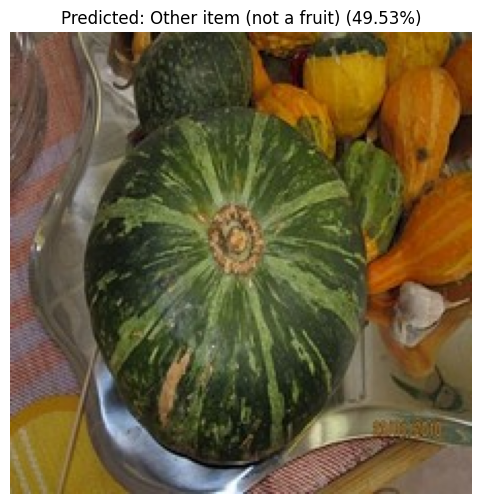


Class Probabilities:
apple fruit: 4.74%
banana fruit: 44.44%
grapes fruit: 1.28%
mango fruit: 49.53%
strawberry fruit: 0.01%
This image is likely NOT a fruit from the dataset.


In [55]:
def predict_not_fruit(image_path, model, class_names, threshold=0.7):
    """
    Predict if the image is a fruit from known classes or 'other' (not a fruit in dataset).
    If the highest class probability is below the threshold, classify as 'other item'.
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img_array = img_resized / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx]

    if confidence < threshold:
        label = "Other item (not a fruit)"
    else:
        label = class_names[predicted_class_idx]

    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f"Predicted: {label} ({confidence*100:.2f}%)")
    plt.axis('off')
    plt.show()

    print("\nClass Probabilities:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {predictions[0][i]*100:.2f}%")
    if confidence < threshold:
        print("This image is likely NOT a fruit from the dataset.")

    return label, confidence

# Example usage (update the path to a non-fruit image):
label, confidence = predict_not_fruit('/Users/anshulagarwal/Downloads/vegetableclassificationcomputervision/Vegetable Images/test/Pumpkin/1162.jpg', model, class_names)

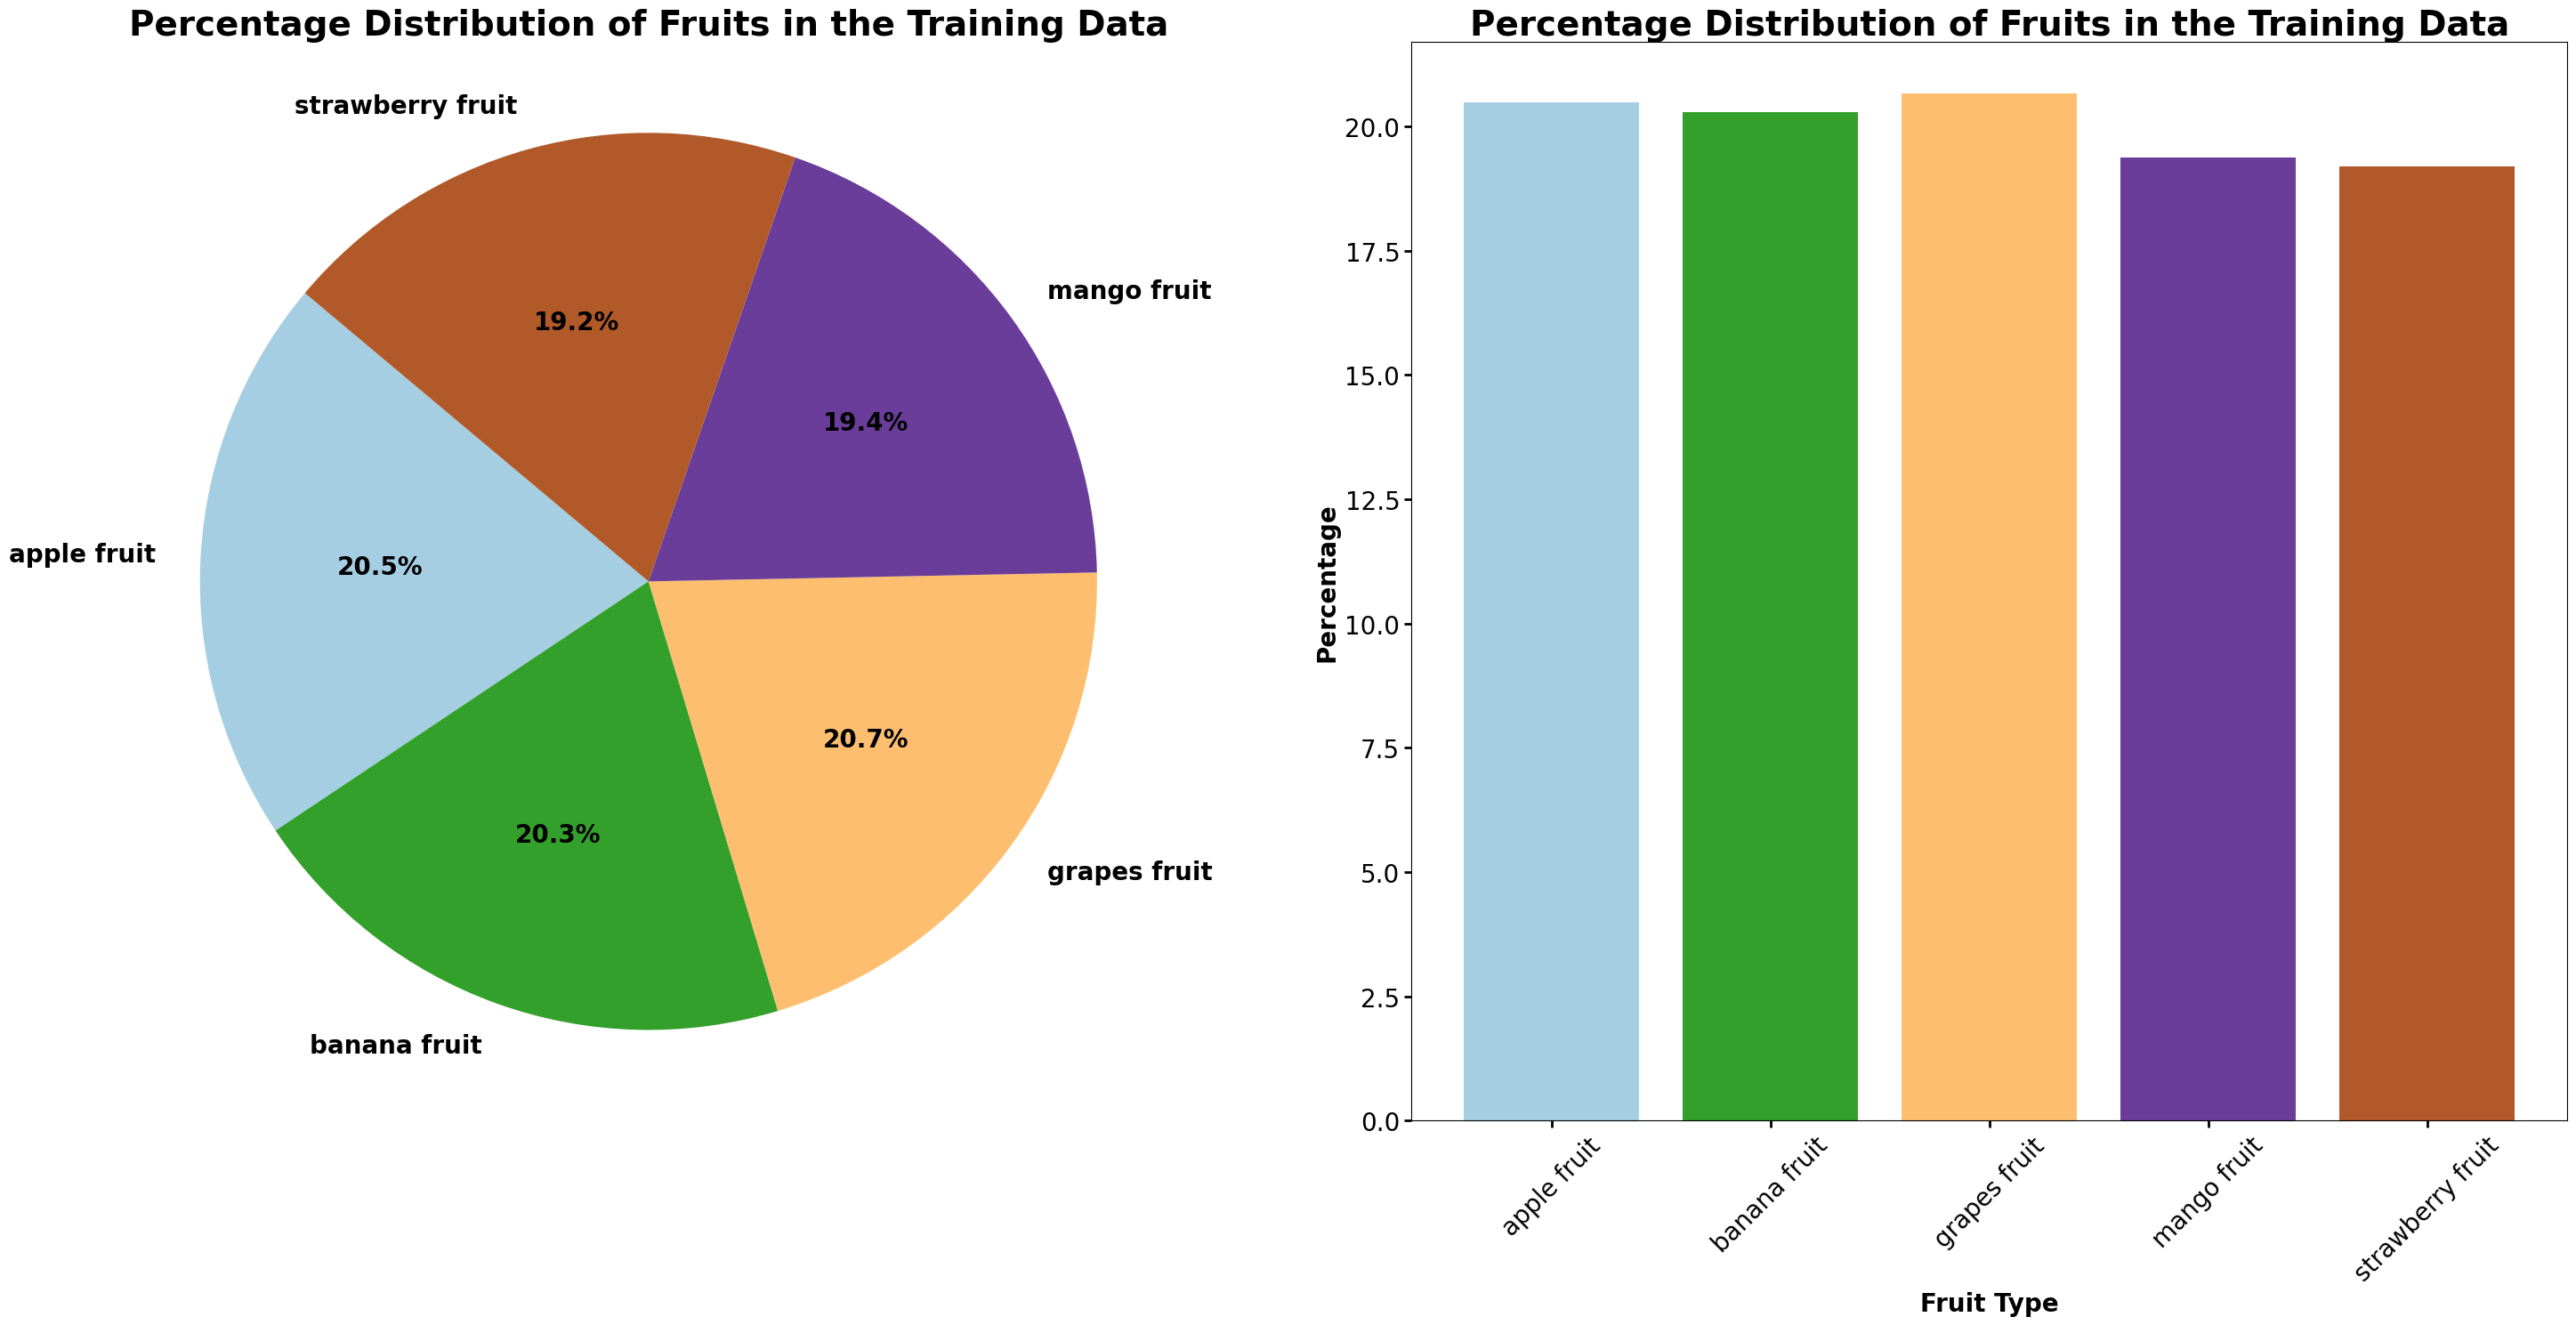

In [56]:
#Calculating percentages of fruits of training data

class_indices = train_generator.class_indices
class_labels=list(class_indices.keys())

#counting number of samples in  each class

num_classes = len(class_labels)
class_counts = np.zeros(num_classes)

#iteration and occurence count

for _,labels in train_generator:
  class_counts+=labels.sum(axis=0)
  if train_generator.batch_index==0:
    break

# Calculate percentage distribution
class_percentages = (class_counts / class_counts.sum()) * 100

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(30, 15))

# Plot the pie chart
axs[0].pie(class_percentages, labels=class_labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(np.linspace(0, 1, num_classes)), textprops={'fontsize': 20, 'fontweight': 'bold'})
axs[0].set_title('Percentage Distribution of Fruits in the Training Data', fontsize=28, fontweight='bold')
axs[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Plot the bar chart
axs[1].bar(class_labels, class_percentages, color=plt.cm.Paired(np.linspace(0, 1, num_classes)))
axs[1].set_xlabel('Fruit Type', fontsize=20, fontweight='bold')
axs[1].set_ylabel('Percentage', fontsize=20, fontweight='bold')
axs[1].set_title('Percentage Distribution of Fruits in the Training Data', fontsize=28, fontweight='bold')
axs[1].tick_params(axis='x', rotation=45, labelsize=20, width=2, length=6)  # Set the tick parameters for x-axis
axs[1].tick_params(axis='y', labelsize=20, width=2, length=6)  # Set the tick parameters for y-axis

# Make labels bold
for ax in axs:
    ax.xaxis.label.set_fontweight('bold')
    ax.yaxis.label.set_fontweight('bold')

# Display the plots
plt.tight_layout()
plt.show()
